## Load data

In [1]:
%matplotlib inline
import data

forms_df,cognates_df,lects_df = data.load_romance_dataset()
display(forms_df)

len(forms_df["Language_ID"].unique())

language = "Italic_Latino-Faliscan_Latin"
# language = "French_Modern_Standard"


Loading data...
Loaded data.


,ID,Language_ID,Cell,Form,Cognateset_ID
0,form_0,Catalan_Western_from_Lleida,[INF],ˈtindɾe,[tenere]
1,form_1,Catalan_Western_from_Lleida,[GER],teˈnin,[tenere]
2,form_2,Catalan_Western_from_Lleida,[PST-PTCP],tiŋˈgut,[tenere]
3,form_3,Catalan_Western_from_Lleida,"[IMP, 2SG]",ˈtiŋges,[tenere]
4,form_4,Catalan_Western_from_Lleida,"[IMP, 2SG]",ˈtiŋgos,[tenere]
...,...,...,...,...,...
155024,form_155024,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, NOM, F]",wolaːtaj,[uolare]
155025,form_155025,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, NOM, N]",wolaːta,[uolare]
155026,form_155026,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, ACC, M]",wolaːtoːs,[uolare]
155027,form_155027,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, ACC, F]",wolaːtaːs,[uolare]


## Filter data

In [2]:
forms_df_1cognate = data.filter_romance_empty_multicog(forms_df)
display(forms_df_1cognate)

,ID,Language_ID,Cell,Form,Cognateset_ID,Cognateset_ID_first
0,form_0,Catalan_Western_from_Lleida,[INF],ˈtindɾe,[tenere],tenere
1,form_1,Catalan_Western_from_Lleida,[GER],teˈnin,[tenere],tenere
2,form_2,Catalan_Western_from_Lleida,[PST-PTCP],tiŋˈgut,[tenere],tenere
3,form_3,Catalan_Western_from_Lleida,"[IMP, 2SG]",ˈtiŋges,[tenere],tenere
4,form_4,Catalan_Western_from_Lleida,"[IMP, 2SG]",ˈtiŋgos,[tenere],tenere
...,...,...,...,...,...,...
155024,form_155024,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, NOM, F]",wolaːtaj,[uolare],uolare
155025,form_155025,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, NOM, N]",wolaːta,[uolare],uolare
155026,form_155026,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, ACC, M]",wolaːtoːs,[uolare],uolare
155027,form_155027,Italic_Latino-Faliscan_Latin,"[PST-PTCP, PL, ACC, F]",wolaːtaːs,[uolare],uolare


## Filter on Latin inflection classes

In [3]:
latin_conjugation_df = data.filter_romance_inflections(forms_df_1cognate, cognates_df)
print(len(latin_conjugation_df))
grouped_by_lang = latin_conjugation_df.groupby("Language_ID").count().sort_values(by="ID_x", ascending=False).head(10)
display(grouped_by_lang)
#grouped_by_lang["Form"].to_csv("langs.tex", sep="&", line_terminator = "\\\\\n")


86290


,ID_x,Cell,Form,Cognateset_ID,Cognateset_ID_first,ID_y,Etymon,Derived_from,Language_of_the_etymon,Latin_Conjugation,Part_Of_Speech,LemLat_ID
Language_ID,,,,,,,,,,,,
Italic_Latino-Faliscan_Latin,15651,15651,15651,15651,15651,15651,15651,2344,15651,15651,15651,15651
Swiss_Raeto-Romance_Surselvan,2980,2980,2980,2980,2980,2980,2980,383,2980,2980,2980,2760
Swiss_Raeto-Romance_Puter_Upper_Engadine,2726,2726,2726,2726,2726,2726,2726,147,2726,2726,2726,2583
Galego-Portuguese_Portuguese,2713,2713,2713,2713,2713,2713,2713,124,2713,2713,2713,2514
French_Modern_Standard,2700,2700,2700,2700,2700,2700,2700,381,2700,2700,2700,2643
Spanish_Modern_Standard,2328,2328,2328,2328,2328,2328,2328,108,2328,2328,2328,2328
Italian_Central_Modern_Standard,2155,2155,2155,2155,2155,2155,2155,96,2155,2155,2155,2107
Romanian_Modern_Standard,1952,1952,1952,1952,1952,1952,1952,148,1952,1952,1952,1767
Occitan_Southern_Provencal_from_Nice,1852,1852,1852,1852,1852,1852,1852,48,1852,1852,1852,1792


## Show type and token frequency of inflection classes for specific language

In [4]:
import pandas as pd
language_df = latin_conjugation_df[latin_conjugation_df["Language_ID"]==language]
print("Token count")
display(language_df.groupby("Latin_Conjugation").count()["Form"])

print("Type count")
display(language_df.drop_duplicates(subset="Cognateset_ID_first").groupby("Latin_Conjugation").count()["Form"])

Token count


Latin_Conjugation
I          4959
II         2354
III        6318
IV         1416
special     604
Name: Form, dtype: int64

Type count


Latin_Conjugation
I          72
II         35
III        93
IV         21
special    10
Name: Form, dtype: int64

## Create dataset per language

In [5]:
import evaluation
import numpy as np

forms_onehot, inflections_onehot, forms, inflections, cogids = data.create_language_dataset(latin_conjugation_df, language, empty_symbol=True, sample_first=1000)
forms_inflections_onehot = np.concatenate((forms_onehot, inflections_onehot), axis=1)

inflections_empty = np.zeros(inflections_onehot.shape)
forms_empty_inflections_onehot = np.concatenate((forms_onehot, inflections_empty), axis=1)

print(len(forms_empty_inflections_onehot))


/home/peter/.pyenv/versions/env37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/peter/.pyenv/versions/env37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/peter/.pyenv/versions/env37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/peter/.pyenv/versions/env37/lib/python3.7/s

1000


## Plot forms without inflection class

/home/peter/.pyenv/versions/env37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


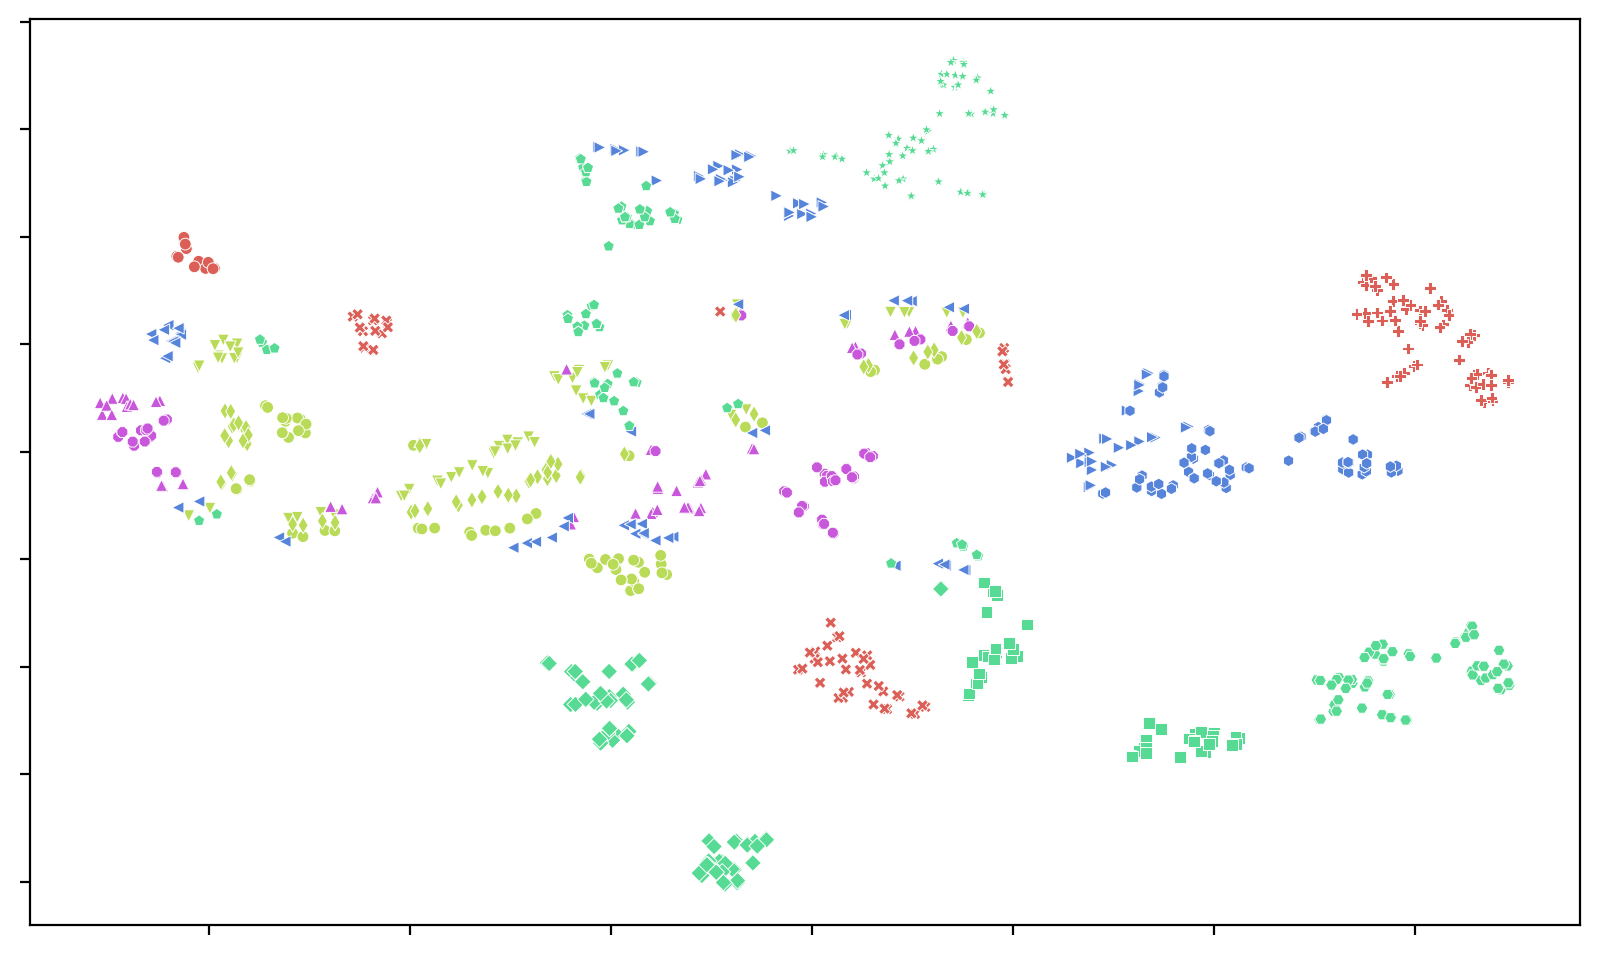

Silhouette score: 0.06719528216718136


<Figure size 2000x1200 with 0 Axes>

In [6]:
score = evaluation.plot_data(forms_empty_inflections_onehot, labels=None, clusters=inflections, micro_clusters=cogids, file_label=f"data-{language}")
print (f"Silhouette score: {score}")

## Plot forms with inflection class

/home/peter/.pyenv/versions/env37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


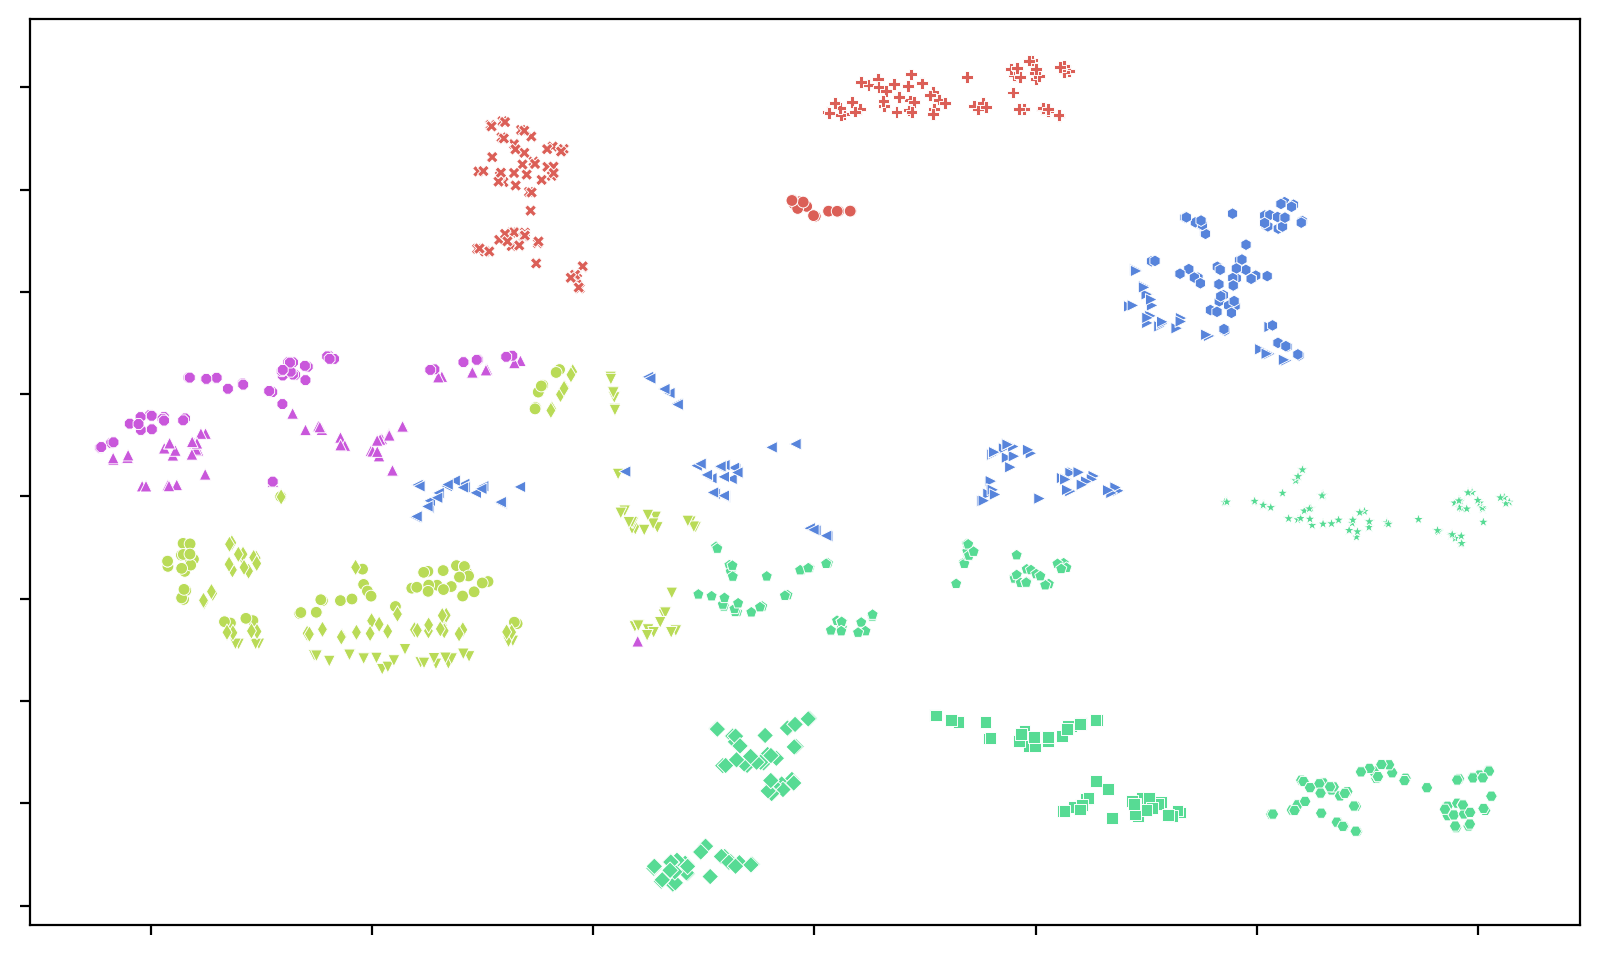

Silhouette score: 0.16296225666706157


<Figure size 2000x1200 with 0 Axes>

In [7]:
score = evaluation.plot_data(forms_inflections_onehot, labels=None, clusters=inflections, micro_clusters=cogids, file_label=f"data-inflections-{language}")
print (f"Silhouette score: {score}")

## ART 1 run

In [8]:
from model import art_one

art_one(forms_empty_inflections_onehot, inflections, cogids, vigilances = np.arange(0,1.05,0.05), data_plot=True)



TypeError: art_iterated_no() missing 1 required positional argument: 'n_timesteps'

## ART iterated, for different batch sizes

In [ ]:
# from model import art_iterated

# for bs in [10,20,50,100,200,500]:
#     print(f"Batch size: {bs}")
#     art_iterated(forms_empty_inflections_onehot, n_runs=20, n_timesteps=500, batch_size=bs, inflections_gold=inflections, cogids=cogids, vigilances=[0.25, 0.5, 0.75] )


In [ ]:
# TODO:
# PCA before TSNE? What is number of dimensions of data, more than 50?
# Evaluated clustering using B-Cubed, or method corresponding to sklearn clustering section.Evaluation per inflection class

In [ ]:
## Iff Language_of_the_etymon is Latin, it has inflection classes
# print(cognates_df[~cognates_df["Latin_Conjugation"].isnull()]["Language_of_the_etymon"].unique()) # only if
# print(cognates_df[cognates_df["Latin_Conjugation"].isnull()]["Language_of_the_etymon"].unique()) # if

## Get lemma for every form in cognateset id list
#cognates_df_lookup = cognates_df.set_index("ID")
#forms_df["inflection_classes"] = forms_df["Cognateset_ID"].apply(lambda cids: [cognates_df_lookup.loc[cid]["Latin_Conjugation"] for cid in cids])